# Explainable Boosting Machine (EBM) - REVISED

Ommit using month and year as features, such as freyberger et al.

In [2]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: m-janyellow. Use `wandb login --relogin` to force relogin


True

In [3]:
# import basic libraries
from datetime import datetime
import pickle

from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
import matplotlib.pyplot as plt
%matplotlib inline
#pt.style.use("seaborn")
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from src.utils import data_loader, time_series_splitter
from src.ebm.plot import visualize_sample_prediction, importance_bar_chart, plot_shape_function
from src.ebm.train import EbmPipeline, save_model, load_model, normalize_target, denormalize, validate_model, rmse, evaluate_model

root_path = "./data/"
model_dir = "./models/ebm/"

In [3]:
# # configure interpret to plot in notebook not using a local host
# from interpret.provider import InlineProvider
# from interpret import set_visualize_provider

# set_visualize_provider(InlineProvider())

In [4]:
subsample_path = 'subsample_processed_scaled_1000.csv'
subsample = data_loader(root_path, subsample_path, pickle=False)
#subsample.shape'

In [51]:
# Load full dataset with multiindex enabled
fullsample_path = 'data_processed_scaled.pkl'
fullsample = data_loader(root_path, fullsample_path, pickle=True)
#data.shape

### Hyperparameter tuning
(https://towardsdatascience.com/bayesian-optimization-for-hyperparameter-tuning-how-and-why-655b0ee0b399)

In [6]:
from skopt import BayesSearchCV

# Lets try Bayesian search first
X_train, X_test, _, y_train, y_test, _ = time_series_splitter(subsample)

In [7]:
# Bayesian Search for hyperparm tuning
n_iter = 32

param_grid = {
    "learning_rate": (0.0001, 0.1, "log-uniform"),
    "max_rounds": (3000, 4000,  5000, 6000) ,
    "early_stopping_rounds": (30, 50),
    "max_bins": (128, 256),
    "early_stopping_tolerance" : (0.00001, 0.01, "log-uniform")
}

reg_bay = BayesSearchCV(estimator=ExplainableBoostingRegressor(random_state=0, n_jobs=-2),
                    search_spaces=param_grid,
                    n_iter=n_iter,
                    cv=5,
                    n_jobs=8,
                    scoring='neg_mean_squared_error',
                    random_state=0)

start_time = datetime.now()

# Run Bayes Search (this takes a while)
model_bay = reg_bay.fit(X_train, y_train)

execution_time = (datetime.now() - start_time).total_seconds()
print(f"Optimization took {np.round(execution_time/60),2} minutes.")

# model can be saved, used for predictions or scoring
best_parms = model_bay.best_params_

with open(f'best_params_ebm.pkl', 'wb') as f:
        pickle.dump(best_parms, f)

Optimization took (12.0, 2) minutes.


In [11]:
with open(f'{model_dir}best_params_ebm.pkl', 'wb') as f:
        pickle.dump(best_parms, f)

In [12]:
# model can be saved, used for predictions or scoring
best_parms = model_bay.best_params_
best_score = model_bay.best_score_
best_estimator = model_bay.best_estimator_
cv_results = model_bay.cv_results_
print(f"Best params are: {best_parms} \n with best score of {best_score} ")

Best params are: OrderedDict([('early_stopping_rounds', 38), ('early_stopping_tolerance', 3.91595624545083e-05), ('learning_rate', 0.00025746896437686993), ('max_bins', 164), ('max_rounds', 4000)]) 
 with best score of -0.012647079720771882 


In [9]:
# fixed best parms identified by bayessearch and experiments and rounded them
best_parms_0 = dict([('early_stopping_rounds', 37), ('early_stopping_tolerance', 0.0002), 
                    ('learning_rate', 0.00061), ('max_bins', 230), ('max_rounds', 3000)])

best_params_1 = dict([('early_stopping_rounds', 37), ('early_stopping_tolerance', 0.00020919480782183626), 
                     ('learning_rate', 0.000609840586504895), ('max_bins', 230), ('max_rounds', 3000)])

with open(f'best_params_ebm_0.pkl', 'wb') as f:
        pickle.dump(best_parms_0, f)

## Modelling

Split data into train and test sets using slicing (like in https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b37). <br/>

Set sizes according to Freyberger et al, 2019 (p.2356):

Train size: 1965 to 1985
Test size: 1986 to 1990

In [6]:
# load saved hyperparams
with open(f'{model_dir}best_params_ebm.pkl', 'rb') as f:
        best_parms = pickle.load(f)

In [7]:
def normalize_target(data):
    """
    Normalizes target variable y of a dataset.
    """
    scaler = StandardScaler()
    target = data.TARGET.values.reshape(-1, 1)
    #print(target.shape)
    data['TARGET'] = scaler.fit_transform(target)
    return data

### Experiment: Train on fullsample, all features

In [52]:
wandb.init(project="interpretable-ml", group="ebm-studies")

# Training procedure
model = ExplainableBoostingRegressor(random_state=0)

# setup hyperparams
param_dict = dict(best_parms)
model.set_params(**param_dict)

##### get data (without extra features to be comparable with freyberger et al)########
data = fullsample
# normalize target
data = normalize_target(data)
print("Dataset has shape: ", data.shape)

# # dont remove any cols
# try:
#     data.drop(['mm_sin', 'mm_cos', 'yy', 'stock'], axis=1, inplace=True) # cols can only be dropped once
# except:
#     pass
#print("Dataset has shape ", data.shape)

# split the data
X_train, X_valid, X_test, y_train, y_valid, y_test = time_series_splitter(data)

model.fit(X_train, y_train)

ebm_global_123 = model.explain_global()


ebm_local_123 = model.explain_local(X_test[:5], y_test[:5])
show(ebm_local_123)

Dataset has shape:  (1363261, 68)


<!-- http://127.0.0.1:7001/2526609112224/ -->

In [53]:
show(ebm_global_123)

<!-- http://127.0.0.1:7001/2526616458288/ -->

In [54]:
import pickle

# get feature imprtances from global explan object
importances_dict = ebm_global_123.data()
try:
    importances_dict.pop('type')
except:
    pass

feature_importance_df = pd.DataFrame(importances_dict)
feature_importance_df.rename(columns={"names": "feature", "scores": "importance score"}, inplace=True)

# save feat importance data
with open(model_dir+'feature_importance_df_123f.pkl', 'wb') as f:
    pickle.dump(feature_importance_df, f)

In [58]:
features = X_train.columns

# save feat feature names
with open(model_dir+'feature_names_all.pkl', 'wb') as f:
    pickle.dump(features, f)

In [56]:
save_shape_data(ebm_global=ebm_global, model_dir=model_dir, run_id='123f')

In [57]:
train_metrics = evaluate_model(model=model, X=X_train, y=y_train, set_type="Train")
valid_metrics = evaluate_model(model=model, X=X_valid, y=y_valid, set_type="Valid")
test_metrics = evaluate_model(model=model, X=X_test, y=y_test, set_type="Test")

# metric logging
wandb.log({"mse_train": train_metrics['mse'], "rmse_train": train_metrics['rmse'], "mae_train" : train_metrics['mae'],
            "mse_test": valid_metrics['mse'], "rmse_test": valid_metrics['rmse'], "mae_test" : valid_metrics['mae'],
            "n_features": X_train.shape[1]})
wandb.finish()

------------- Train performance: -------------
R-squared: 0.0949783639119548
Mean absolute error: 0.5762548412712808
Mean squared error: 0.6566670175106445
Root mean squared error: 0.8103499352197447 

------------- Valid performance: -------------
R-squared: -0.0017167763831484883
Mean absolute error: 0.6328993271242856
Mean squared error: 0.8674256825011217
Root mean squared error: 0.9313569039316355 

------------- Test performance: -------------
R-squared: -0.013136311788627175
Mean absolute error: 0.6854124312956572
Mean squared error: 1.1665374442682734
Root mean squared error: 1.0800636297312642 



mae_test,▁
mae_train,▁
mse_test,▁
mse_train,▁
n_features,▁
rmse_test,▁
rmse_train,▁
mae_test,0.6329
mae_train,0.57625
mse_test,0.86743
mse_train,0.65667


### Experiment: Train on subsample without temporal features


In [13]:
wandb.init(project="interpretable-ml", group="ebm-studies")

# Training procedure
model = ExplainableBoostingRegressor(random_state=0)

# setup hyperparams
param_dict = dict(best_parms)
model.set_params(**param_dict)

##### get data (without extra features to be comparable with freyberger et al)########
data = fullsample
# normalize target
data = normalize_target(data)
print("Dataset has shape: ", data.shape)

# remove cols not used by freyberger
try:
    data.drop(['mm_sin', 'mm_cos', 'yy', 'stock'], axis=1, inplace=True) # cols can only be dropped once
except:
    pass
print("Dataset has shape ", data.shape)

# split the data
X_train, X_valid, X_test, y_train, y_valid, y_test = time_series_splitter(data)

model.fit(X_train, y_train)

ebm_global = model.explain_global()
show(ebm_global)

ebm_local = model.explain_local(X_test[:5], y_test[:5])
#show(ebm_local)

Dataset has shape:  (1363261, 64)
Dataset has shape  (1363261, 64)


<!-- http://127.0.0.1:7001/2526616757680/ -->

In [7]:
with open(f"{model_dir}")

c:\Users\ASUS\anaconda3\envs\ml-seminar\lib\site-packages\interpret\visual\udash.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
c:\Users\ASUS\anaconda3\envs\ml-seminar\lib\site-packages\interpret\visual\udash.py:6: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
c:\Users\ASUS\anaconda3\envs\ml-seminar\lib\site-packages\interpret\visual\udash.py:7: UserWarning: 
The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`
  import dash_table as dt


<!-- http://127.0.0.1:7001/1330600271936/ -->

In [14]:
pipe = EbmPipeline()

def evaluate_model(model, X, y, set_type="train"):
    # pred
    y_pred = model.predict(X)

    # performance metrics
    r_squared = model.score(X,y)
    mae = mean_absolute_error(y, y_pred) 
    mse = mean_squared_error(y, y_pred)
    rmse_ = rmse(y, y_pred)
    
    # print metrics
    print(f"------------- {set_type} performance: -------------")
    print(f"R-squared: {r_squared}")
    print(f"Mean absolute error: {mae}")
    print(f"Mean squared error: {mse}")
    print(f"Root mean squared error: {rmse_} \n")

    metrics = {
        "r-squared" : r_squared,
        "mae" : mae,
        "mse" : mse,
        "rmse" : rmse_
    }

    return metrics

In [15]:
train_metrics = evaluate_model(model=model, X=X_train, y=y_train, set_type="Train")
valid_metrics = evaluate_model(model=model, X=X_valid, y=y_valid, set_type="Valid")
test_metrics = evaluate_model(model=model, X=X_test, y=y_test, set_type="Test")

------------- Train performance: -------------
R-squared: 0.04760534452447429
Mean absolute error: 0.5905535615989956
Mean squared error: 0.6910400071842576
Root mean squared error: 0.8312881613401322 

------------- Valid performance: -------------
R-squared: -0.016188861176429592
Mean absolute error: 0.6376472556138091
Mean squared error: 0.8799576259855388
Root mean squared error: 0.9380605662671995 

------------- Test performance: -------------
R-squared: -0.016920329607144957
Mean absolute error: 0.6848544987797497
Mean squared error: 1.1708944083053103
Root mean squared error: 1.0820787440409827 



In [16]:
# metric logging
wandb.log({"mse_train": train_metrics['mse'], "rmse_train": train_metrics['rmse'], "mae_train" : train_metrics['mae'],
            "mse_test": valid_metrics['mse'], "rmse_test": valid_metrics['rmse'], "mae_test" : valid_metrics['mae'],
            "n_features": X_train.shape[1]})
wandb.finish()

mae_test,▁
mae_train,▁
mse_test,▁
mse_train,▁
n_features,▁
rmse_test,▁
rmse_train,▁
mae_test,0.63765
mae_train,0.59055
mse_test,0.87996
mse_train,0.69104


In [18]:
# get feature imprtances from global explan object
importances_dict = ebm_global.data()
try:
    importances_dict.pop('type')
except:
    pass

feature_importance_df = pd.DataFrame(importances_dict)
feature_importance_df.rename(columns={"names": "feature", "scores": "importance score"}, inplace=True)

In [21]:
import pickle
with open(model_dir+'feature_importance_df_120f.pkl', 'wb') as f:
    pickle.dump(feature_importance_df, f)

c:\Users\ASUS\Documents\seminar-interpretable-ml\src\ebm\plot.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



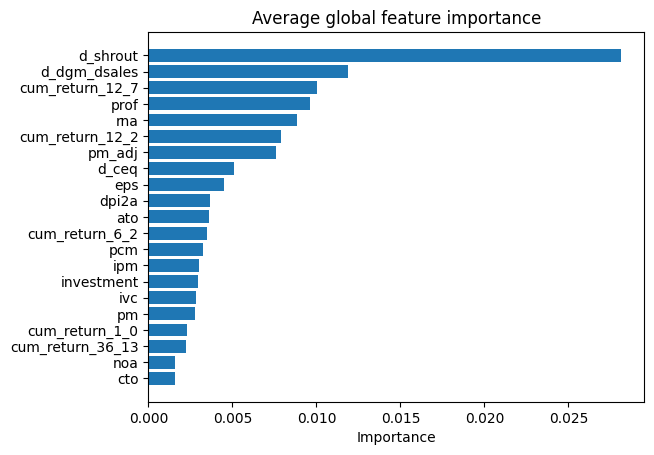

In [19]:
importance_bar_chart(feature_importance_df[0:21], save=True, id='120_full')

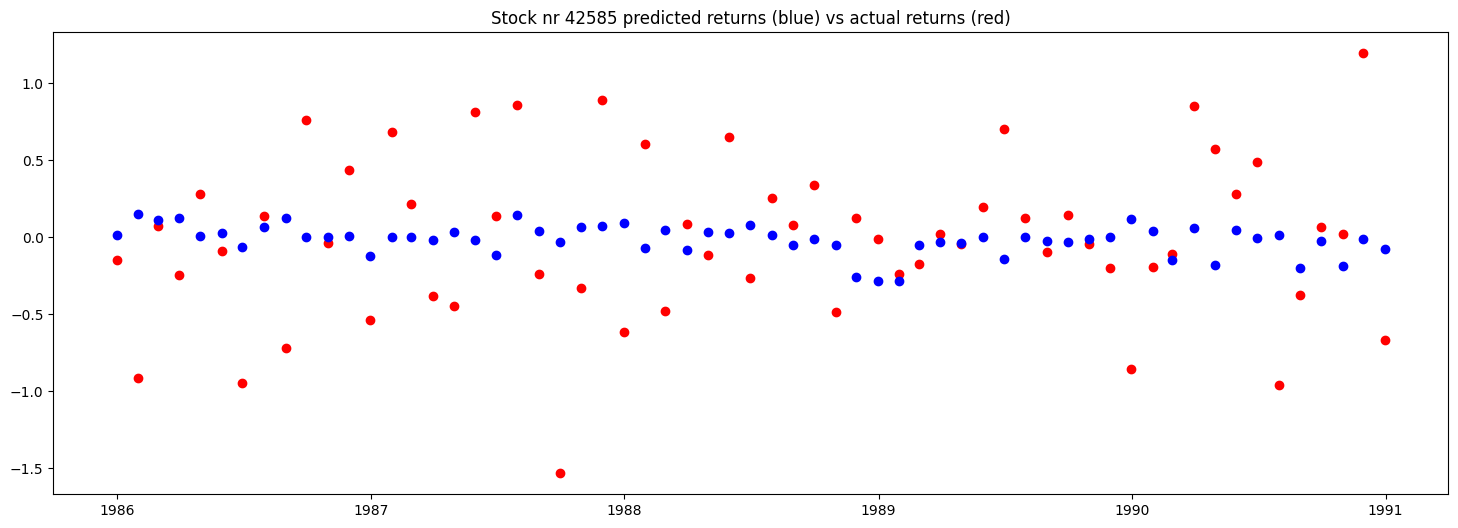

In [72]:
y_pred = model.predict(X_valid)

## lets see the preds visualized
visualize_sample_prediction(y_valid, y_pred, subsample)

### Experiment: Train on fullsample, w/o months

In [10]:
# Training procedure
model = ExplainableBoostingRegressor(random_state=0)

# setup hyperparams
# param_dict = dict(best_parms)
# model.set_params(**param_dict)

##### get data (without extra features to be comparable with freyberger et al)########
data = fullsample
# normalize target
data = normalize_target(data)
print("Dataset has shape: ", data.shape)

# remove cols not used by freyberger
try:
    data.drop(['mm_sin', 'mm_cos'], axis=1, inplace=True) # cols can only be dropped once
except:
    pass
print("Dataset has shape ", data.shape)

# split the data
X_train, X_valid, X_test, y_train, y_valid, y_test = time_series_splitter(data)

model.fit(X_train, y_train)

ebm_global = model.explain_global()
show(ebm_global)

ebm_local = model.explain_local(X_test[:5], y_test[:5])
#show(ebm_local)

Dataset has shape:  (1363261, 66)
Dataset has shape  (1363261, 66)


<!-- http://127.0.0.1:7001/2260581211488/ -->

In [13]:
# evaluate model performance on different data sets
evaluate_model(model=model, X=X_train, y=y_train, set_type="Train")
evaluate_model(model=model, X=X_valid, y=y_valid, set_type="Valid")
evaluate_model(model=model, X=X_test, y=y_test, set_type="Test")

------------- Train performance: -------------
R-squared: 0.22551499763286498
Mean absolute error: 0.5345392157028552
Mean squared error: 0.5619520421738005
Root mean squared error: 0.7496346057739066 

------------- Valid performance: -------------
R-squared: -0.07951536297955974
Mean absolute error: 0.6653526578876858
Mean squared error: 0.9347945173525036
Root mean squared error: 0.9668477219048011 

------------- Test performance: -------------
R-squared: -0.061356224340148424
Mean absolute error: 0.7109079648564316
Mean squared error: 1.2220584367508989
Root mean squared error: 1.1054675195368242 



{'r-squared': -0.061356224340148424,
 'mae': 0.7109079648564316,
 'mse': 1.2220584367508989,
 'rmse': 1.1054675195368242}

In [22]:
# save feat_importances
# get feature imprtances from global explan object
def save_feature_importance(ebm_global, save=False, id="00"):
    importances_dict = ebm_global.data()
    try:
        importances_dict.pop('type')
    except:
        pass

    feature_importance_df = pd.DataFrame(importances_dict)
    feature_importance_df.rename(columns={"names": "feature", "scores": "importance score"}, inplace=True)

    feature_importance_df.sort_values(by='importance score', ascending=False, axis=0, inplace=True)

    if save:
        with open(model_dir+f"feature_importance_df_{id}.pkl", "wb") as f:
            pickle.dump(feature_importance_df, f)
    
    return feature_importance_df

# feature_importance_df = save_feature_importance(ebm_global=ebm_global, save=True)

# importance_bar_chart(feature_importance_df[0:21], model_dir, save=True, id="120")

### Experiment: Train on subsample, without month

In [7]:
# Training procedure
model = ExplainableBoostingRegressor(random_state=0)

# setup hyperparams
param_dict = dict(best_parms)
model.set_params(**param_dict)

##### get data (without extra features to be comparable with freyberger et al)########
data = subsample
# normalize target
data = normalize_target(data)
print("Dataset has shape: ", data.shape)

# remove cols not used by freyberger
try:
    data.drop(['mm_sin', 'mm_cos'], axis=1, inplace=True) # cols can only be dropped once
except:
    pass
print("Dataset has shape ", data.shape)

# split the data
X_train, X_valid, X_test, y_train, y_valid, y_test = time_series_splitter(data)

model.fit(X_train, y_train)

ebm_global = model.explain_global()
show(ebm_global)

ebm_local = model.explain_local(X_test[:5], y_test[:5])
#show(ebm_local)


Dataset has shape:  (220700, 68)
Dataset has shape  (220700, 66)


c:\Users\ASUS\anaconda3\envs\ml-seminar\lib\site-packages\interpret\visual\udash.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
c:\Users\ASUS\anaconda3\envs\ml-seminar\lib\site-packages\interpret\visual\udash.py:6: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
c:\Users\ASUS\anaconda3\envs\ml-seminar\lib\site-packages\interpret\visual\udash.py:7: UserWarning: 
The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`
  import dash_table as dt


<!-- http://127.0.0.1:7001/1773015693200/ -->

In [8]:
# evaluate model performance on different data sets
evaluate_model(model=model, X=X_train, y=y_train, set_type="Train")
evaluate_model(model=model, X=X_valid, y=y_valid, set_type="Valid")
evaluate_model(model=model, X=X_test, y=y_test, set_type="Test")

------------- Train performance: -------------
R-squared: 0.0671665651340394
Mean absolute error: 0.591288758106941
Mean squared error: 0.6900720045434093
Root mean squared error: 0.8307057268030655 

------------- Valid performance: -------------
R-squared: -0.02226864296631681
Mean absolute error: 0.6390847189121126
Mean squared error: 0.8682673769555435
Root mean squared error: 0.9318086589829178 

------------- Test performance: -------------
R-squared: -0.015470458492702344
Mean absolute error: 0.6909583025790342
Mean squared error: 1.1789178671325746
Root mean squared error: 1.0857798428468703 



{'r-squared': -0.015470458492702344,
 'mae': 0.6909583025790342,
 'mse': 1.1789178671325746,
 'rmse': 1.0857798428468703}

In [4]:
with open('./models/ebm/feature_importance_df_122.pkl', "rb") as f:
    feature_importance_df = pickle.load(f)

c:\Users\ASUS\Documents\seminar-interpretable-ml\src\ebm\plot.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_importance_df.sort_values(by='importance score', ascending=False, axis=0, inplace=True)


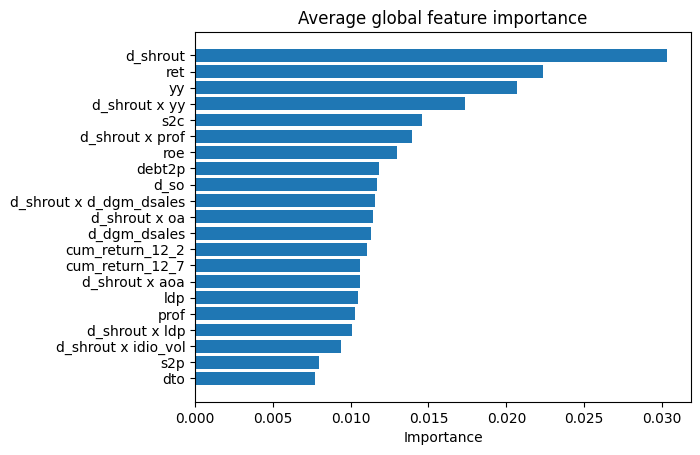

In [5]:
importance_bar_chart(feature_importance_df[0:21], model_dir, save=True, id="122")

c:\Users\ASUS\Documents\seminar-interpretable-ml\src\ebm\plot.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



AttributeError: 'NoneType' object has no attribute 'feature'

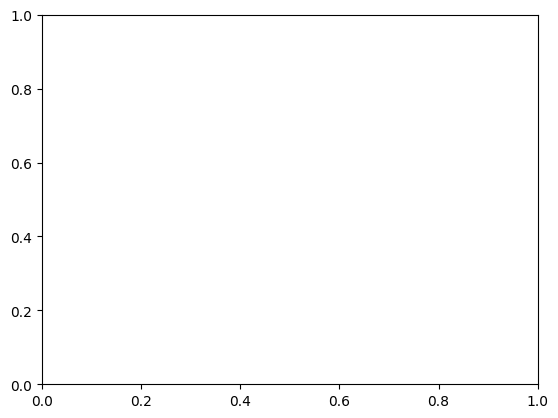

In [12]:
importances_dict = ebm_global.data()
try:
    importances_dict.pop('type')
except:
    pass

feature_importance_df = pd.DataFrame(importances_dict)
feature_importance_df.rename(columns={"names": "feature", "scores": "importance score"}, inplace=True)

#feature_importance_df.sort_values(by='importance score', ascending=False, axis=0, inplace=True)

with open(model_dir+f"feature_importance_df_122.pkl", "wb") as f:
    pickle.dump(feature_importance_df, f)

# get feature imprtances from global explan object
#feature_importance_df = save_feature_importance(ebm_global=ebm_global, save=True)

importance_bar_chart(feature_importance_df[0:21], model_dir, save=True, id="122")

In [14]:
feature_importance_df["importance score"].values.sum()

0.5247334540671328

### Selected features accroding to Freyberger et al (2019) and previous student

In [8]:
## best features used by freyberger et al:
features_freyberger = ['d_shrout', 'd_so', 'investment', 'lme', 'lturnover', 'pm_adj', 
                       'cum_return_1_0', 'cum_return_12_2', 'cum_return_12_7', 'rel_to_high_price', 
                       'roc','suv', 'total_vol','TARGET']

## best features found by random forrest reg
features_rf = ['d_shrout', 'roe', 'oa', 'free_cf', 'nop', 'dpi2a', 'rna', 'ato', 'd_dgm_dsales', 'roc', 'ipm', 'spread_mean', 'dto', 'suv', 'TARGET']

features_ae = ['e2p', 'beme', 'cum_return_12_2', 'cum_return_12_7', 'mm_sin', 'mm_cos', 'yy', 'dpi2a', 'ret', 'total_vol', 'noa', 'std_volume', 'cto', 'TARGET']

# combines features from different feature selection methods
features_combined = ['ato', 'yy', 'spread_mean', 'cum_return_12_7', 'ret',
                     'd_so', 'd_dgm_dsales', 'lturnover', 'roe', 'mm_sin',
                     'ipm', 'dpi2a', 'beme', 'nop', 'lme', 'suv', 'dto', 'noa',
                     'd_shrout', 'total_vol', 'free_cf', 'cum_return_1_0', 'mm_cos',
                     'roc', 'e2p', 'oa', 'cto', 'rna', 'pm_adj', 'std_volume',
                     'rel_to_high_price', 'cum_return_12_2', 'investment', 'TARGET']

features_random = ['d_shrout', 'lme', 'lme_adj', 'lturnover', 'rel_to_high_price',
       'ret_max', 'spread_mean', 'std_turn', 'std_volume', 'suv', 'total_vol',
       'ret', 'yy', 'mm_cos', 'mm_sin', 'stock', 'TARGET']

## conclusion:

Using the union of features of the three methods did not improve but slitely decrease accuracy.
=> More features are not necessarily better.
=> More tuning does not help either 

**Two more ideas**

1) visualize results in an aggregated way: mean returns over all stocks per month e.g.

2) use only a few features, i.e. the top 3 of the above methods + returns (maximum)

A thought: standardize per stock not globally - would this change model performanee?

## Try custom plotting using code 
provided by Nico Hambauer [https://github.com/interpretml/interpret/issues/325]

In [41]:
feat_for_vis = dict()
for i, n in enumerate(ebm_global.data()['names']):
    feat_for_vis[n] = {'importance': ebm_global.data()['scores'][i]}
    

In [55]:
def save_shape_data(ebm_global, model_dir, run_id='00'): 
    shape_data_list = []
    for i in range(len(ebm_global.data()['names'])):
        data_names = ebm_global.data()
        feature_name = data_names['names'][i]
        shape_data = ebm_global.data(i)
        shape_data_list.append(shape_data)
    with open(f'{model_dir}shape_data_{run_id}.pkl', 'wb') as f:
        pickle.dump(shape_data_list, f)

In [47]:
save_shape_data(ebm_global=ebm_global, model_dir=model_dir, run_id='120f')

In [10]:
def plot_all(fitted_model, num_cols, dataset_name='', scaler_dict={}, run_id=''):
    
    ebm_global = fitted_model.explain_global()

    for i in range(len(ebm_global.data()['names'])):
        data_names = ebm_global.data()
        feature_name = data_names['names'][i]
        shape_data = ebm_global.data(i)

        if shape_data['type'] == 'interaction':
            # x_name, y_name = feature_name.split('x')
            # x_name = x_name.replace(' ', '')
            # y_name = y_name.replace(' ', '')
            # make_plot_interaction(shape_data['left_names'], shape_data['right_names'],
            #                       np.transpose(shape_data['scores']),
            #                       x_name, y_name, model_name, dataset_name)
            continue
        if len(shape_data['names']) == 2:
            pass
            # make_one_hot_plot(shape_data['scores'][0], shape_data['scores'][1], feature_name, model_name, dataset_name)
        else:
            plot_shape_function(data_dict=shape_data, feature_name=feature_name, num_cols=num_cols, scaler_dict={}, run_id=run_id)

    # feat_for_vis = dict()
    # for i, n in enumerate(ebm_global.data()['names']):
    #     feat_for_vis[n] = {'importance': ebm_global.data()['scores'][i]}
    # feature_importance_visualize(feat_for_vis, save_png=True, folder='.', name='ebm_feat_imp')

In [12]:
# TO-DO: save scaler PER FEATURE, not per date!!!!!!
import pickle
# get scaler for inverse transformation
with open('data/rank_standard_scaler_x.pkl', 'rb') as f:
    scaler_dict = pickle.load(f)

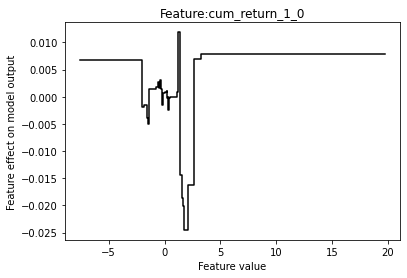

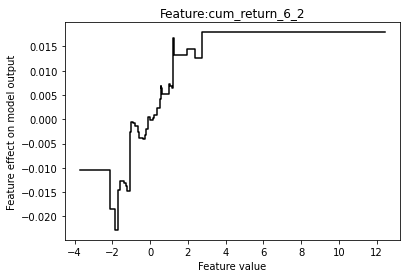

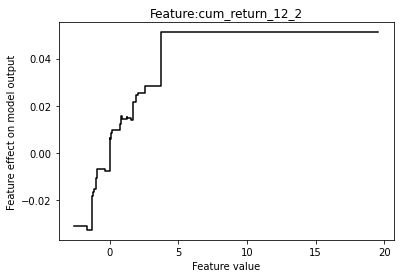

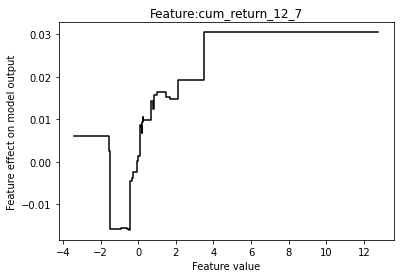

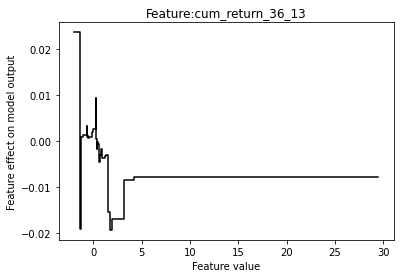

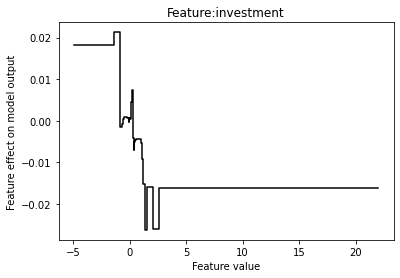

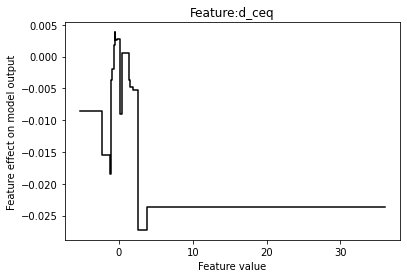

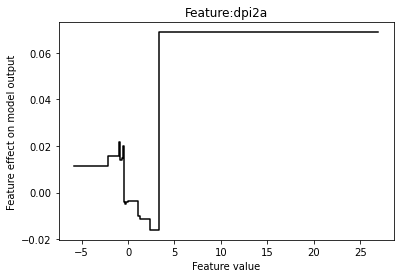

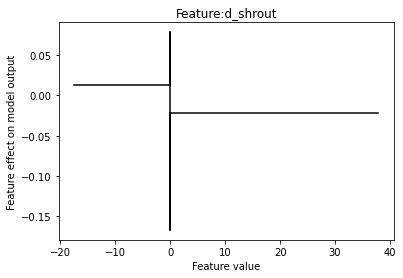

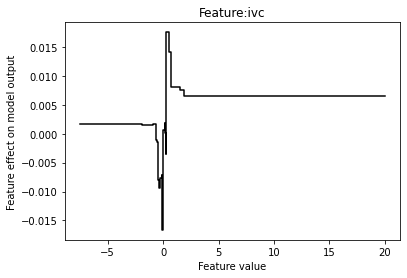

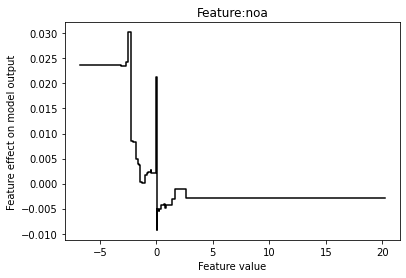

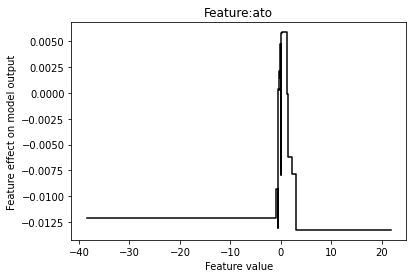

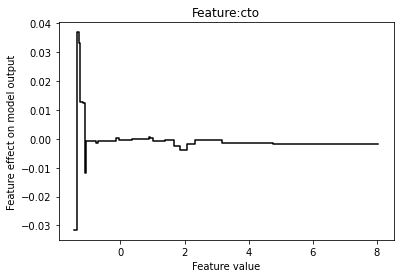

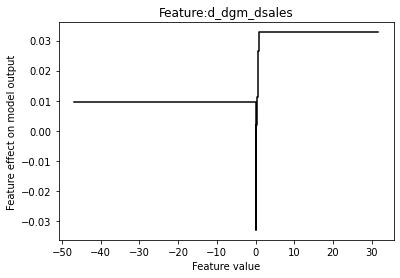

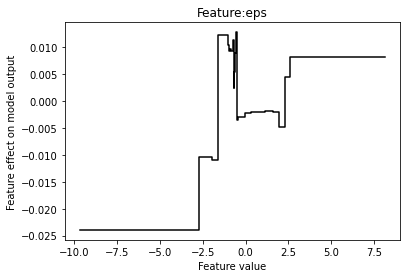

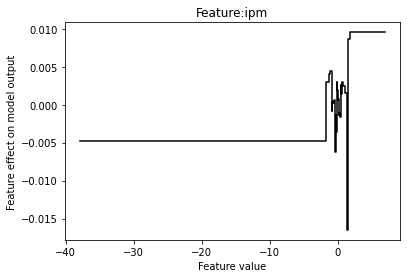

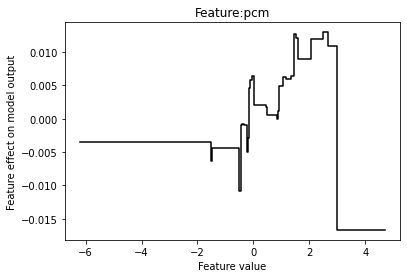

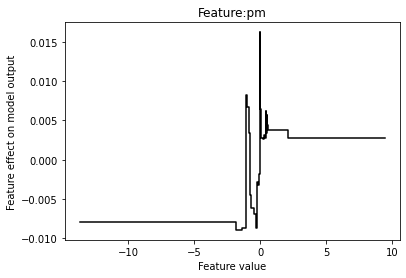

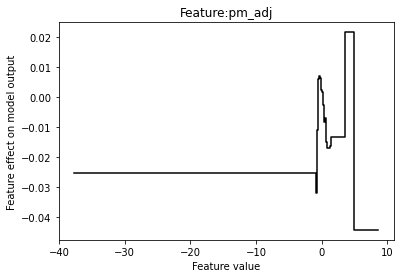

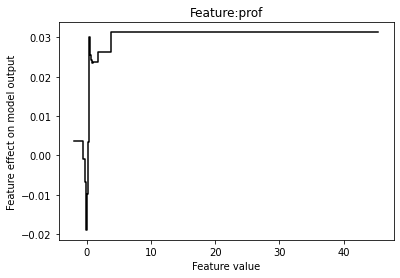

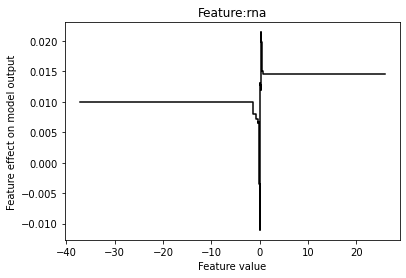

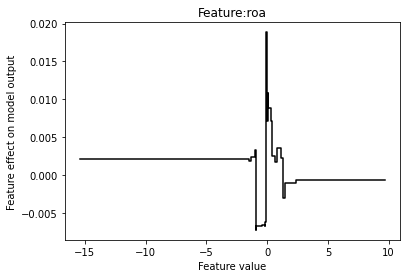

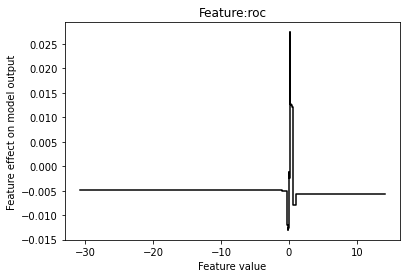

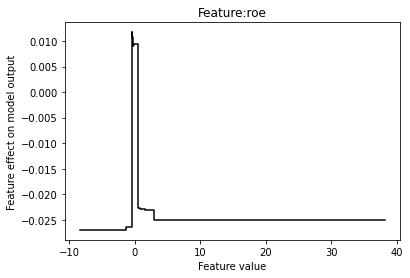

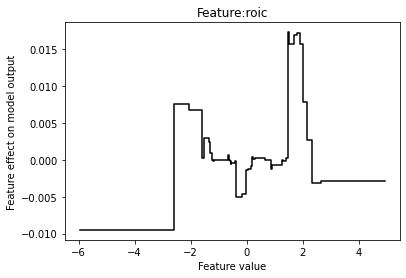

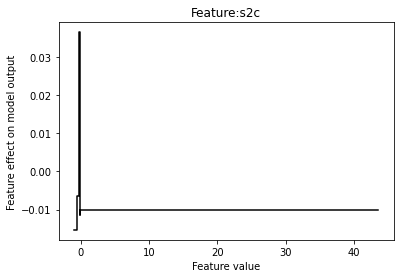

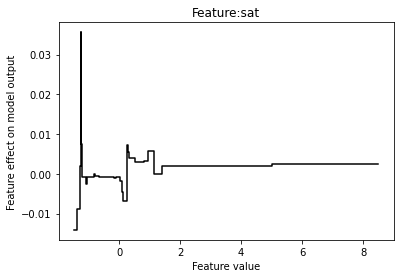

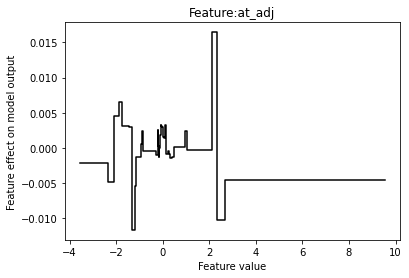

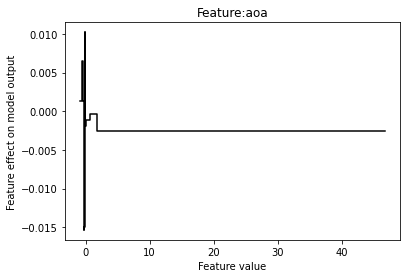

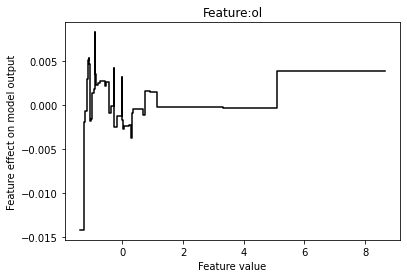

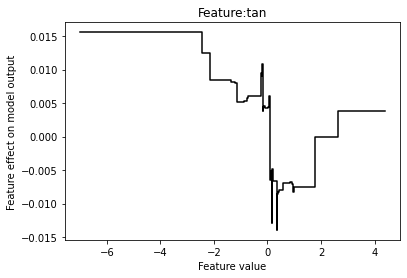

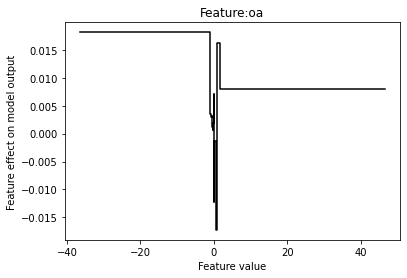

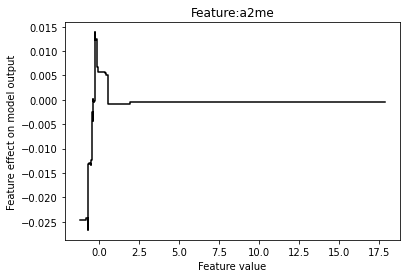

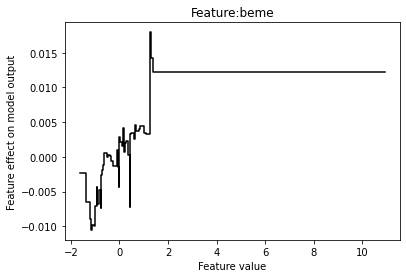

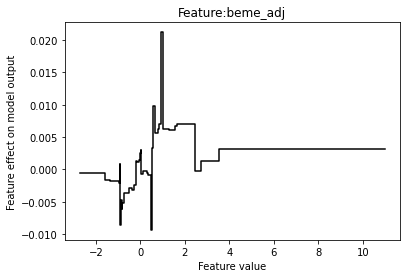

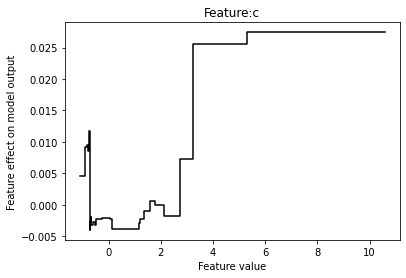

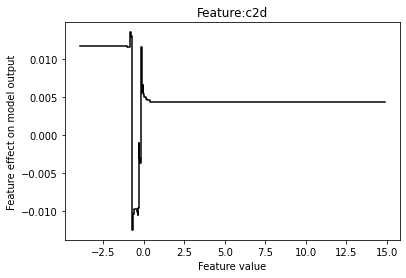

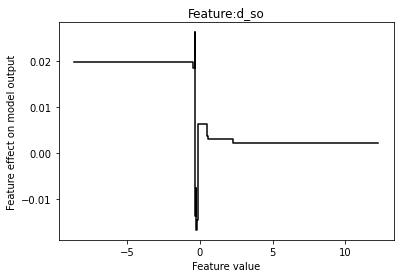

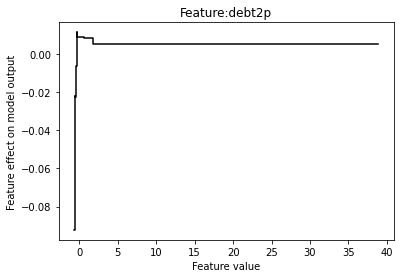

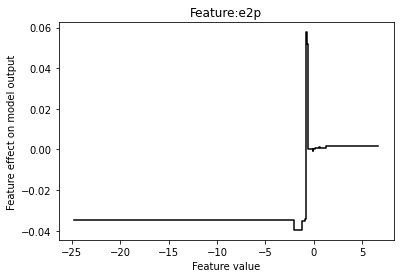

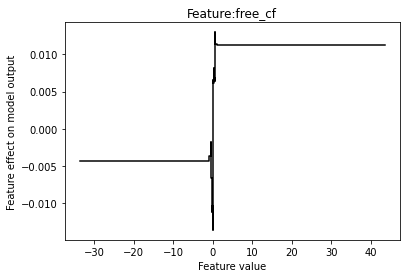

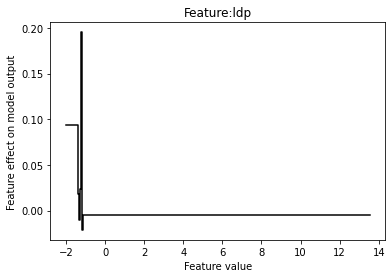

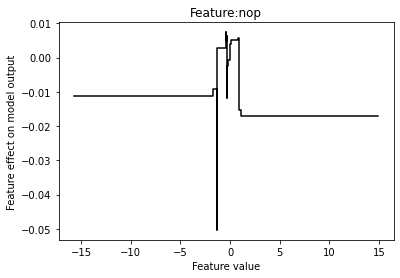

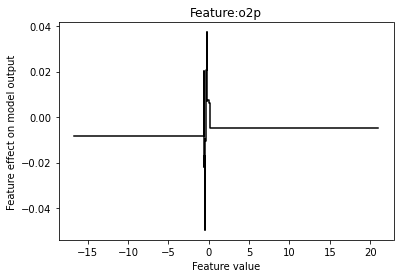

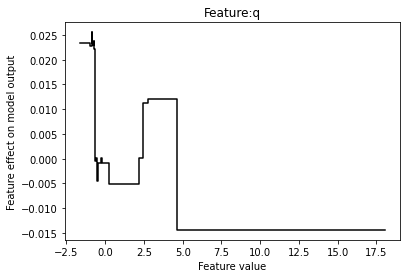

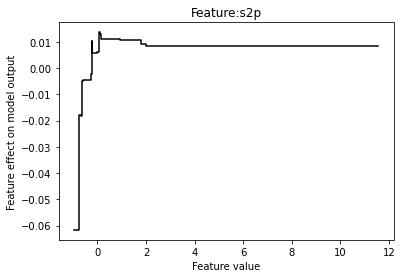

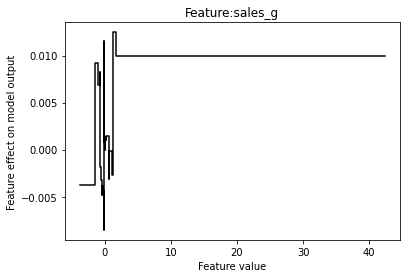

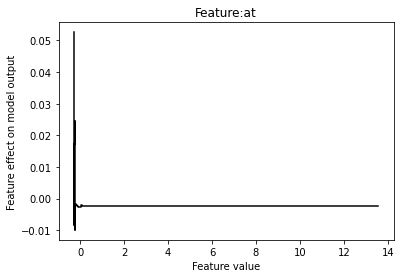

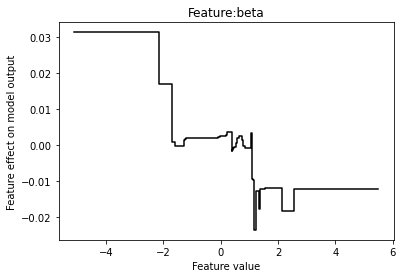

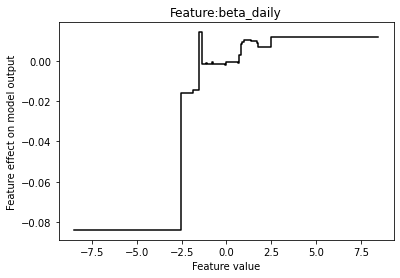

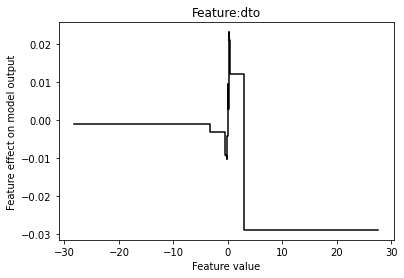

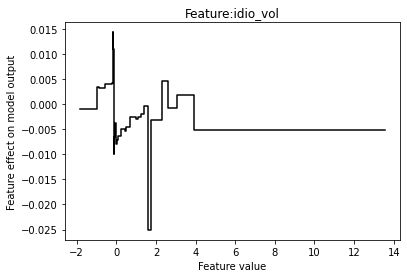

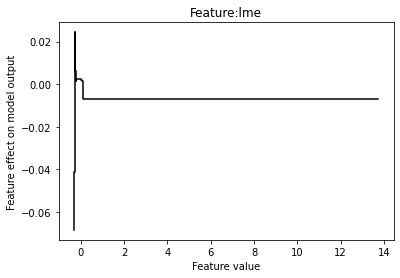

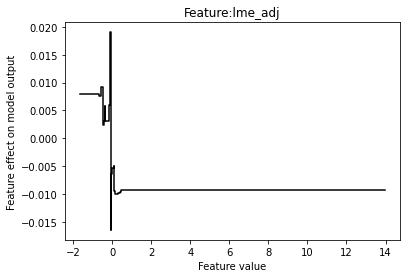

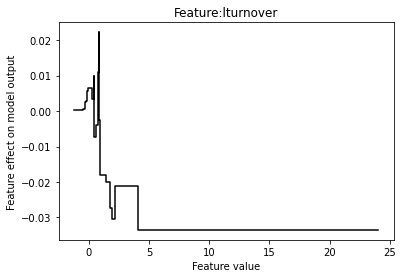

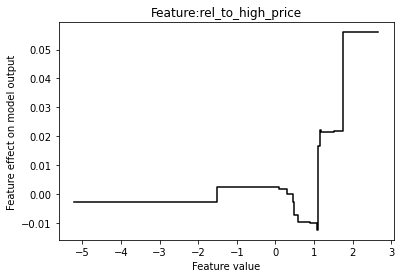

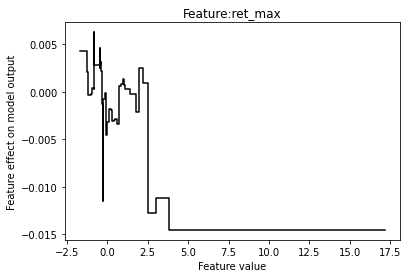

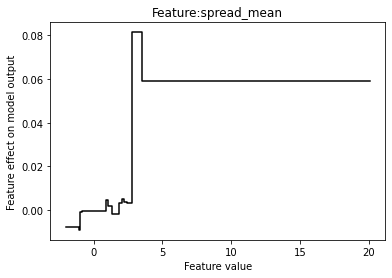

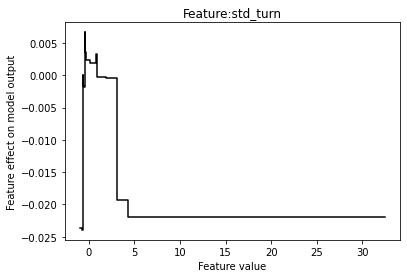

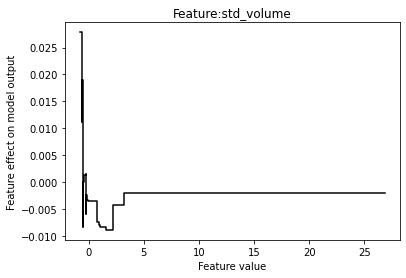

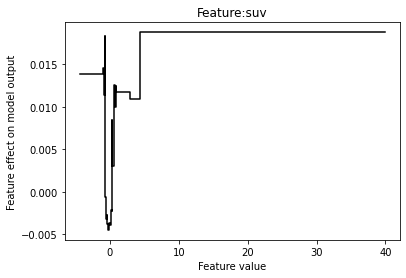

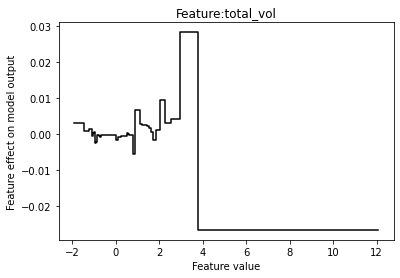

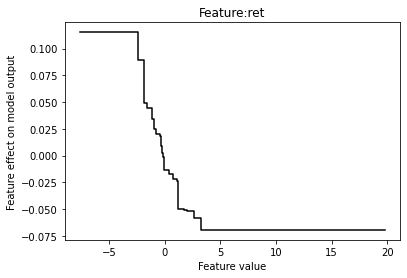

In [11]:
# plot
scaler_dict={}
columns = X_train.columns.values
plot_all(model, columns, 'subsample', scaler_dict ,'140_e')

date
1963-07-31    StandardScaler()
1963-08-31    StandardScaler()
1963-09-30    StandardScaler()
1963-10-31    StandardScaler()
1963-11-30    StandardScaler()
                    ...       
2013-12-31    StandardScaler()
2014-01-31    StandardScaler()
2014-02-28    StandardScaler()
2014-03-31    StandardScaler()
2014-04-30    StandardScaler()
Length: 610, dtype: object